In [7]:
import math
import matplotlib.pyplot as plt
# calculus
import sympy as sym
import random
import numpy as np

## Capture probability function

In [8]:
def P_cap(Px, Py, CR):
    # calculate power ratio threshold
    Pr = 10 ** (CR / 10)
    
    slope_1 = math.sqrt(Py * Pr / Px)
    slope_2 = math.sqrt(Py / (Px * Pr))

    if slope_1 > 1 and slope_2 < 1:
        result = (1 / math.sqrt(Pr * Py / Px) / 2) + (math.sqrt(Py / (Pr * Px)) / 2)
    elif slope_1 > 1 and slope_2 >= 1:
        result = 1 - (1 / math.sqrt(Py / (Pr * Px)) - 1 / math.sqrt(Pr * Py / Px)) / 2
    elif slope_1 <= 1 and slope_2 < 1:
        result = 1 - (math.sqrt(Pr * Py / Px) - math.sqrt(Py / (Pr * Px))) / 2
    return result

In [9]:
# sta_amount: Total contend stations number
# RA_RU: RA_RU number reserved for UORA
# Lmax: Retransmit limit
# TXOP: Transaction Opportunity (time length in ms)
# ocw_min: minimum OCW
# ocw_max: maximum OCW
# CR: Capture Ratio (CR=infinite = no capture, CR=0 = always capture)

def analytical(sta_amount, RA_RU, Lmax, TXOP, ocw_min, ocw_max, CR, step):
    access_delay=0
    counter_delay_slot=0
    success_sta=0
    success_packet=0
    success_probability=0
    counter_power=0
    # setting ocw for each transmission [ocw_min, 1st_retry_ocw...ocw_max]
    ocw = [0 for _ in range(0, Lmax+1) ]
    ocw[1] = ocw_min
    for n in range (2, Lmax+1):
        temp_ocw = ocw[n-1] * 2 + 1
        if temp_ocw <= ocw_max:
            ocw[n] = temp_ocw
        else:
            ocw[n] = ocw[n-1]
    # Imax: Reserved slot for transmission (total slots in worst case)
    Imax = 0
    for z in range(1,Lmax+1):
        Imax += math.ceil(ocw[z] / RA_RU)
    # Ri: RA_RU number i-th slot, (Ri[i])
    Ri = [RA_RU for _ in range(0,Imax+1)]
    # M: Arrival number for i-th slot, (M[i])
    M  = [0 for _ in range(0,Imax+1)]
    # M_i: Arrival number for i-th slot and n-th transmission (M_i[n])
    M_i    = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_s  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Fail stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_f  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot (M_i_s_C[i])
    M_i_s_C = [0 for _ in range(0,Imax+1)]
    
    # set power for its n-th transmission
    power_n = [2 ** (x if x <= (step - 1) else (step - 1)) for x in range(Lmax)]

    for i in range (1,Imax+1):
        # calculate Mi[n], a_k_i
        for n in range (1, Lmax+1):
            # a_k_i: the portion of STAs that fail their (n − 1)th packet transmissions in the kth 
            # slot and transmit the packet for the nth time in the ith slot (k < i)
            if n == 1:
                if i == 1:
                    M_i[i][n] = min((Ri[i]+1) / (ocw[n]+1), 1) * sta_amount
                elif i >= 2 and i <= math.floor(ocw[n] / Ri[i]):
                    M_i[i][n] = Ri[i] / (ocw[n] + 1) * sta_amount
                elif i == math.ceil(ocw[n] / Ri[i]):
                    M_i[i][n] = (ocw[n] - Ri[i] * math.floor(ocw[n] / Ri[i])) / (ocw[n] + 1) * sta_amount
                else:
                    M_i[i][n] = 0
            elif n <= i:
                #/** Mi[n]=sigma (a_j_i*Mi_F[n-1]) */ 
                for k in range (1, i):
                    if ocw[n] <= Ri[i]:
                        if k == i-1:
                            a_k_i = 1
                        else:
                            a_k_i = 0
                    elif ocw[n] > Ri[i]:
                        if k == (i - math.ceil(ocw[n] / Ri[i])):
                            a_k_i = (ocw[n] - Ri[i] * (math.ceil(ocw[n] / Ri[i]) - 1)) / (ocw[n] + 1)
                        elif k <= (i-2) and k >= (i - math.ceil(ocw[n] / Ri[i]) + 1):
                            a_k_i = Ri[i] / (ocw[n] + 1)
                        elif k == (i - 1):
                            a_k_i = (Ri[i] + 1) / (ocw[n] + 1)
                        else:
                            a_k_i = 0
                    
                    M_i[i][n] += a_k_i * M_i_f[k][n-1]
            M[i] += M_i[i][n]
            

        #/** statistics */ 
        for n in range (1, Lmax+1):
            #/** Calculate capture probability in slot i for its n-th transmission */
            capture_prob = 0
            
            if M[i] > 0:
                for s in range(1, step+1):
                    # sta_ratio is M_i[n] / M_i
                    sta_ratio = 0
                    if (s == step):
                        for k in range(s, Lmax+1):
                            sta_ratio += M_i[i][k] / M[i]
                    else:
                        sta_ratio = M_i[i][s] / M[i]

                    # P is the power of two station
                    # calculate power by n-th transmission
                    P1 = 2 ** ((n-1) if (n-1) <= (step - 1) else (step - 1))
                    # calculate power by s-th step
                    P2 = 2 ** (s - 1)

                    capture_prob += P_cap(P1, P2, CR) * sta_ratio
                    
#             if (Ri[i] == 74):
#                 print(f'n:{n} sta_amount:{sta_amount} capture_prob:{capture_prob}')
#             print(math.exp(-M[i] / Ri[i]))
#             print(f'R={RA_RU}, sta={sta_amount}, n={n}, i={i}')
#             print((M[i]-1) / (2 * Ri[i]) * math.exp(-M[i] / Ri[i]))
            M_i_s[i][n] = M_i[i][n] * math.exp(-M[i] / Ri[i]) + capture_prob * M_i[i][n] * (M[i]-1) / (2 * Ri[i]) * math.exp(-M[i] / Ri[i])
            
            M_i_f[i][n] = M_i[i][n] - M_i_s[i][n]
            M_i_s_C[i] += M_i_s[i][n]

            # power usage (P[1]...P[n])
            counter_power += M_i_s[i][n] * (sum(power_n[:n]))

        #/** performance metric */  
        success_packet += M_i_s_C[i]
        success_sta += M_i_s_C[i]
        counter_delay_slot += M_i_s_C[i] * i
    
    #/** success probability */
    success_probability = success_packet / sta_amount
        
    access_delay = (TXOP * counter_delay_slot) / success_packet
#     Throughput 
    through_put = success_packet / Imax
#     Utilization
    utilization = success_packet / (Imax * RA_RU)
    # sta*success_probability 來算 grouping的Ds
    # Average power usage
    counter_power = counter_power / success_packet

    return Imax,success_probability,access_delay, utilization, through_put, counter_power  # ,sta*success_probability

# CR=1.5

In [10]:
R = [9,18,37,74,148]
Lmax = 5
# sta_max = 200
sta_max = 500

m_list = [i for i in range(1, sta_max+1)]

ps_list = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_PR  = [ [0] * (sta_max) for _ in range(0, len(R))]

da_list = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]

u_list = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]

power_list = [ [0] * (sta_max) for _ in range(0, len(R))]
power_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]

# for r in R:
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=5.673, ocw_min=7, ocw_max=31, CR=1.5, step=4)
        ps_list_PR[idx][sta-1] = Ps
        da_list_PR[idx][sta-1] = Da
        u_list_PR[idx][sta-1] = U
        power_list_PR[idx][sta-1] = power

In [11]:
# Simulation (old -> m=200)

m_list_simu = [(i+1)*10 for i in range(20)]

ps_list_simu_9 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999, 0.9979500000000002, 0.974099999999998, 0.8687000000000005, 0.7059200000000001, 0.5491333333333347, 0.41712857142856924, 0.32055000000000033, 0.25368888888888913, 0.20535999999999927, 0.06156499999999997, 0.03488000000000008, 0.02392999999999997, 0.017829999999999936, 0.014105000000000045, 0.01147571428571427, 0.009617499999999996, 0.008364444444444426, 0.007114999999999952]
da_list_simu_9 = [5.672999999999856, 6.2743379999998545, 7.09314099999988, 7.945036499999941, 8.200888799999987, 9.011560499999987, 9.60114728571425, 10.319187000000026, 10.900354333333308, 11.840622566666697, 19.88470599736852, 27.788888556240977, 34.782427252782455, 39.37127845864676, 43.212889949339726, 46.610564718857944, 49.66604147202496, 52.454654027135035, 54.986266534610564, 68.11449713695733, 71.48950472561877, 73.26342805618327, 74.3675096952591, 75.27843126276814, 75.92738662985353, 76.57588463022824, 77.1678323480189, 77.57963774162525]
t_list_simu_9 = [0.06666666666666801, 0.13333333333333602, 0.19999999999999718, 0.26666666666667205, 0.3333333333333318, 0.39999999999999436, 0.46666666666665557, 0.5333333333333441, 0.6000000000000113, 0.6665999999999971, 1.3305999999999947, 1.948199999999996, 2.3165333333333424, 2.3530666666666673, 2.1965333333333388, 1.9466000000000012, 1.7095999999999982, 1.5221333333333322, 1.3690666666666675, 0.8208666666666664, 0.6976, 0.6381333333333348, 0.5943333333333356, 0.5642000000000029, 0.5355333333333344, 0.5129333333333328, 0.5018666666666658, 0.47433333333333233]
u_list_simu_9 = [0.007407407407407279, 0.014814814814814559, 0.02222222222222215, 0.029629629629629117, 0.0370370370370375, 0.0444444444444443, 0.051851851851851004, 0.059259259259258235, 0.06666666666666801, 0.07406666666666759, 0.1478444444444462, 0.21646666666666858, 0.257392592592593, 0.2614518518518519, 0.24405925925925956, 0.21628888888888925, 0.18995555555555546, 0.1691259259259257, 0.15211851851851826, 0.09120740740740756, 0.07751111111111121, 0.07090370370370393, 0.06603703703703728, 0.06268888888888896, 0.059503703703703774, 0.056992592592592636, 0.05576296296296304, 0.0527037037037037]
power_list_simu_9 = [1.0, 1.156, 1.3640000000000005, 1.5935, 1.6584000000000019, 1.880333333333334, 2.0700000000000043, 2.269, 2.440222222222222, 2.7182, 5.702956140350877, 9.917402513438027, 16.310581924365547, 24.71748807746112, 35.901204645361894, 50.79712481517462, 69.03944195406419, 89.96768829029206, 112.8312966934954, 396.22759254852474, 706.8009823062721, 1059.965450964724, 1399.375702214451, 1780.591269560501, 2197.5770691530765, 2728.719381507378, 3112.0869755244744, 3747.3406759906657]


ps_list_simu_18 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9998499999999999, 0.998, 0.980975000000004, 0.9086200000000032, 0.7743666666666669, 0.6225142857142874, 0.4809124999999996, 0.37385555555555533, 0.2924000000000005, 0.06397000000000005, 0.03391000000000007, 0.021677499999999954, 0.015277999999999951, 0.011251666666666686, 0.007977142857142839, 0.00595624999999999, 0.004349999999999987, 0.003127999999999964]
da_list_simu_18 = [5.672999999999856, 5.916938999999859, 6.149531999999876, 6.326813249999918, 6.61698719999995, 6.864329999999933, 7.015880142857073, 7.35291712500002, 7.591734666666655, 7.979074500000035, 10.883725144736879, 14.618307550273668, 18.553477410782783, 22.103586698268316, 24.902880910757343, 26.950229512978407, 28.757380661325996, 30.41521278079052, 31.99612017745698, 41.844839091896894, 44.399283788237796, 45.124214626227186, 45.29332853356543, 45.34428879534521, 45.378624662418936, 45.3830507028101, 45.383045913217835, 45.38399999999887]
t_list_simu_18 = [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 1.125, 1.25, 2.499625, 3.7425, 4.904875, 5.678875, 5.80775, 5.447, 4.809125, 4.205875, 3.655, 1.59925, 1.271625, 1.083875, 0.954875, 0.843875, 0.698, 0.595625, 0.489375, 0.391]
u_list_simu_18_ramp = [0.0069444444444445785, 0.013888888888889157, 0.02083333333333324, 0.027777777777778314, 0.03472222222222164, 0.04166666666666648, 0.048611111111111965, 0.05555555555555663, 0.0625, 0.06944444444444328, 0.1388680555555532, 0.207916666666669, 0.27249305555555364, 0.31549305555555573, 0.3226527777777781, 0.3026111111111106, 0.267173611111111, 0.23365972222222212, 0.20305555555555532, 0.08884722222222229, 0.07064583333333321, 0.060215277777777854, 0.053048611111111164, 0.04688194444444457, 0.038777777777777814, 0.03309027777777779, 0.027187500000000014, 0.02172222222222224]
power_list_simu_18_ramp = [1.0, 1.087, 1.170666666666667, 1.236, 1.3431999999999982, 1.4316666666666664, 1.4894285714285782, 1.6285, 1.7124444444444367, 1.8819999999999975, 3.2439894736842065, 5.528654369640572, 8.743519471143308, 13.363990411667999, 20.013415146628525, 28.947131195754068, 41.37268644403812, 56.510705996370106, 75.05393280018208, 380.0872356518438, 722.7273477258027, 1144.0396648462654, 1669.815700965697, 2289.9005644355684, 3422.849545454551, 4730.882279942274, 6589.00714285714, 8895.934523809545]


ps_list_simu_37_ramp = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9998499999999999, 0.9993600000000002, 0.9952000000000008, 0.9735571428571409, 0.9207625000000013, 0.8247888888888897, 0.6964600000000006, 0.05512999999999995, 0.004343333333333348, 0.0003850000000000003, 2.0000000000000005e-05, 3.3333333333333337e-06, 0.0, 0.0, 0.0, 0.0]
da_list_simu_37_ramp = [5.672999999999856, 5.777950499999858, 5.888573999999865, 6.026144249999884, 6.107551799999902, 6.2639374999998925, 6.341603571428479, 6.511894874999974, 6.600850666666623, 6.727610700000004, 7.791014550000048, 8.996999800000006, 10.344887182894812, 11.84552764796135, 13.50974363561104, 15.26709040067027, 16.552241326907637, 17.52532143709513, 18.024294826095428, 17.52346584917202, 17.103342172739485, 15.848695804195785, 18.720900000000004, 17.019, 17.019, 17.019, 17.019, 17.019]
t_list_simu_37_ramp = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 7.998799999999999, 9.993600000000002, 11.942400000000017, 13.629800000000058, 14.73220000000002, 14.846199999999993, 13.92919999999998, 2.2052000000000027, 0.26059999999999883, 0.030799999999999928, 0.0019999999999999996, 0.0004, 0.0, 0.0, 0.0, 0.0]
u_list_simu_37_ramp = [0.005405405405405471, 0.010810810810810942, 0.016216216216216387, 0.021621621621621883, 0.02702702702702728, 0.032432432432432774, 0.03783783783783734, 0.043243243243243766, 0.048648648648649366, 0.05405405405405456, 0.10810810810810911, 0.16216216216216145, 0.2161837837837858, 0.27009729729729304, 0.3227675675675666, 0.36837297297297333, 0.3981675675675671, 0.40124864864864834, 0.3764648648648641, 0.05960000000000036, 0.007043243243243285, 0.0008324324324324304, 5.405405405405406e-05, 1.0810810810810812e-05, 0.0, 0.0, 0.0, 0.0]
power_list_simu_37_ramp = [1.0, 1.037, 1.077333333333333, 1.1255, 1.1579999999999981, 1.2163333333333342, 1.2437142857142882, 1.30675, 1.3395555555555467, 1.3886000000000047, 1.8463000000000016, 2.468333333333334, 3.349713157894737, 4.52472989144594, 6.145946822139502, 8.43004098928334, 11.213477025350466, 15.282606704385252, 21.118383378450492, 446.99649989307505, 3603.766066666665, 1262.966, 114.888, 27.572, 0.0, 0.0, 0.0, 0.0]


ps_list_simu_74_ramp = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9998333333333334, 0.9994200000000004, 0.6936700000000001, 0.20756000000000038, 0.05593249999999988, 0.01566599999999993, 0.0045066666666666545, 0.0012685714285714288, 0.0003524999999999985, 0.000102222222222222, 3.100000000000002e-05]
da_list_simu_74_ramp = [5.672999999999856, 5.712710999999858, 5.8148249999998605, 5.823334499999867, 5.884035599999884, 5.98785149999988, 6.040934571428462, 6.069400874999922, 6.111081666666585, 6.16825289999995, 6.724490550000029, 7.3002054999999935, 7.840086000000035, 8.381857500000006, 9.035008899999998, 9.686485414285718, 10.392794175000061, 11.09092114604189, 11.897597005021652, 18.04364686881711, 17.983782974780272, 17.500633162164966, 17.05485322628057, 17.15087085425222, 17.113222837370163, 17.171499999999945, 16.69667045454546, 18.3]
t_list_simu_74_ramp = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 17.997, 19.988399999999995, 27.74680000000002, 12.45360000000002, 4.4746000000000015, 1.5666000000000018, 0.5407999999999995, 0.17759999999999979, 0.05640000000000018, 0.018399999999999975, 0.006200000000000003]
u_list_simu_74_ramp = [0.0027027027027027354, 0.005405405405405471, 0.008108108108108194, 0.010810810810810942, 0.01351351351351364, 0.016216216216216387, 0.01891891891891867, 0.021621621621621883, 0.024324324324324683, 0.02702702702702728, 0.05405405405405456, 0.08108108108108072, 0.10810810810810911, 0.13513513513513292, 0.16216216216216145, 0.1891891891891912, 0.21621621621621823, 0.24320270270270836, 0.2701135135135093, 0.37495675675675616, 0.16829189189189153, 0.06046756756756752, 0.021170270270270276, 0.007308108108108133, 0.0023999999999999976, 0.000762162162162158, 0.00024864864864864865, 8.378378378378379e-05]
power_list_simu_74_ramp = [1.0, 1.014, 1.0500000000000003, 1.054, 1.0743999999999982, 1.1123333333333334, 1.1308571428571454, 1.14125, 1.1573333333333287, 1.176200000000004, 1.387200000000002, 1.621866666666666, 1.8713, 2.132279999999996, 2.490266666666665, 2.8848285714285713, 3.3692250000000077, 3.90060335376234, 4.5679765367965395, 21.119846901068588, 100.30708875522471, 417.33933854588776, 1721.0808755569585, 6140.627726190475, 7228.505133333333, 4253.308, 1779.015, 712.608]


NameError: name 'ps_list_simu_9' is not defined

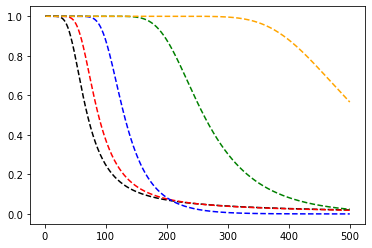

In [12]:
# plt.plot(m_list, ps_list[0], color='black', label='ana R=9')
# plt.plot(m_list, ps_list[1], color='red', label='ana R=18')
# plt.plot(m_list, ps_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, ps_list[3], color='green', label='ana R=74')
# plt.plot(m_list, ps_list[4], color='orange', label='ana R=148')

plt.plot(m_list, ps_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, ps_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, ps_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, ps_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.plot(m_list, ps_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.plot(m_list_simu, ps_list_simu_9, label='sim_PR R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, ps_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, ps_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, ps_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, ps_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)


plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 1.5', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Ps", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
plt.axis([10,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

In [ ]:
# plt.plot(m_list, da_list[0], color='black', label='ana R=9')
# plt.plot(m_list, da_list[1], color='red', label='ana R=18')
# plt.plot(m_list, da_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, da_list[3], color='green', label='ana R=74')
# plt.plot(m_list, da_list[4], color='orange', label='ana R=148')

plt.plot(m_list, da_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, da_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, da_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, da_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
# plt.plot(m_list, da_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.plot(m_list_simu, da_list_simu_9, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=4)
plt.plot(m_list_simu, da_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=4)
plt.plot(m_list_simu, da_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=4)
plt.plot(m_list_simu, da_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=4)
# plt.plot(m_list_simu, da_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=4)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 1.5', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Da", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,60]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

In [ ]:
# plt.plot(m_list, u_list[0], color='black', label='ana R=9')
# plt.plot(m_list, u_list[1], color='red', label='ana R=18')
# plt.plot(m_list, u_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, u_list[3], color='green', label='ana R=74')
# plt.plot(m_list, u_list[4], color='orange', label='ana R=148')

plt.plot(m_list, u_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, u_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, u_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, u_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.plot(m_list, u_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.plot(m_list_simu, u_list_simu_9, label='sim_PR R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, u_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, u_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, u_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, u_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 1.5', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("U", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,0.35]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

In [ ]:
plt.plot(m_list, power_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, power_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, power_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, power_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.plot(m_list, power_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.plot(m_list_simu, power_list_simu_9, label='sim_PR R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, power_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, power_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, power_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, power_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR=1.5', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Power", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,0.35]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

# CR=3

In [ ]:
R = [9,18,37,74,148]
Lmax = 5
sta_max = 200
# sta_max = 500
m_list = [i for i in range(1, sta_max+1)]

ps_list = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_PR  = [ [0] * (sta_max) for _ in range(0, len(R))]

da_list = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]

u_list = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]

power_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=5.673, ocw_min=7, ocw_max=31, CR=3, step=4)
        ps_list_PR[idx][sta-1] = Ps
        da_list_PR[idx][sta-1] = Da
        u_list_PR[idx][sta-1] = U
        power_list_PR[idx][sta-1] = power
        

In [ ]:
# Simulation (old -> m=200)

# m_list_simu = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
m_list_simu = [(i+1)*10 for i in range(20)]

ps_list_simu_9 = [0.9999, 0.9994000000000001, 0.9839666666666655, 0.9131250000000007, 0.7680200000000003, 0.6079000000000006, 0.4678428571428567, 0.3643125000000004, 0.2894000000000005, 0.23193999999999992, 0.19017272727272744, 0.16120000000000048, 0.13930769230769294, 0.12133571428571419, 0.10804000000000032, 0.09679375000000003, 0.08770000000000043, 0.07985000000000014, 0.07368947368421042, 0.06734999999999997]
da_list_simu_9 = [10.893546733333364, 18.21744115526327, 26.005936781517583, 32.76336046800707, 38.109718527517764, 42.271540139196425, 45.62202688203117, 48.68873589055671, 51.550946775061206, 54.106544795673, 56.6476813606658, 58.76583089807649, 60.33945795479798, 62.05709951194807, 63.43267926548923, 64.4410750976717, 65.4874689116935, 66.50173095519577, 67.04590466355262, 67.7060404873556]
t_list_simu_9 = [0.6665999999999971, 1.3325333333333274, 1.967933333333331, 2.435000000000006, 2.5600666666666663, 2.431600000000002, 2.1832666666666674, 1.942999999999994, 1.736399999999999, 1.546266666666664, 1.3946000000000005, 1.2896000000000039, 1.2073333333333347, 1.132466666666669, 1.0804000000000016, 1.0324666666666662, 0.9939333333333324, 0.9581999999999984, 0.9333999999999992, 0.897999999999999]
u_list_simu_9 = [0.07406666666666759, 0.14805925925926108, 0.21865925925926186, 0.27055555555555555, 0.28445185185185135, 0.2701777777777772, 0.24258518518518538, 0.215888888888889, 0.19293333333333287, 0.17180740740740705, 0.15495555555555546, 0.14328888888888885, 0.13414814814814818, 0.12582962962962974, 0.12004444444444483, 0.1147185185185187, 0.11043703703703699, 0.10646666666666664, 0.10371111111111117, 0.09977777777777769]
power_list_simu_9 = [2.421377777777777, 4.989746198830408, 8.412295190377957, 11.608534430972632, 14.071276539738953, 15.807094515549151, 17.01211823434028, 18.079396902863596, 18.912208093599283, 19.65908153056324, 20.361813023181682, 20.854581753651704, 21.2347457584684, 21.614148652596548, 21.88515656899975, 22.1098271574127, 22.31208085269903, 22.48771145625067, 22.549219096713433, 22.654164742115427]


ps_list_simu_18 = [1.0, 0.99995, 0.9994333333333333, 0.9914000000000026, 0.9461000000000057, 0.8441833333333345, 0.7045571428571437, 0.5568250000000003, 0.4328777777777776, 0.3405799999999998, 0.2721545454545458, 0.21849999999999978, 0.1827461538461544, 0.15248571428571403, 0.1297333333333336, 0.11263750000000004, 0.09808235294117686, 0.08807222222222225, 0.0776263157894737, 0.07062500000000009]
da_list_simu_18 = [7.567782000000035, 10.168449418421092, 13.391814213793078, 17.16667074971846, 20.95029277772687, 23.988457263334976, 26.182919298439263, 28.135485769709405, 29.808296720427577, 31.277757088071574, 32.805373027552115, 34.17465186550592, 35.36850220447649, 36.575638911803196, 37.756653624712, 38.636756418644616, 39.56195449375628, 40.35256364749227, 41.06096297438236, 41.53177721662874]
t_list_simu_18 = [1.25, 2.499875, 3.747875, 4.957, 5.913125, 6.331375, 6.164875, 5.56825, 4.869875, 4.25725, 3.742125, 3.2775, 2.969625, 2.6685, 2.4325, 2.25275, 2.08425, 1.981625, 1.843625, 1.765625]
u_list_simu_18 = [0.06944444444444328, 0.1388819444444421, 0.20821527777778023, 0.2753888888888856, 0.32850694444444517, 0.35174305555555574, 0.342493055555556, 0.30934722222222194, 0.27054861111111134, 0.23651388888888894, 0.2078958333333333, 0.18208333333333357, 0.1649791666666667, 0.14824999999999994, 0.1351388888888889, 0.12515277777777772, 0.11579166666666667, 0.11009027777777795, 0.10242361111111123, 0.09809027777777782]
power_list_simu_18 = [1.7118000000000049, 2.8614105263157907, 4.6775310344827625, 7.2195067153961885, 10.050121016352916, 12.294306852970966, 13.90608001638532, 15.228633634624993, 16.270434476803263, 17.127367609868084, 17.988492734311667, 18.737146893745827, 19.330704641038018, 19.942796753829505, 20.517376294501236, 20.887872081268686, 21.351599879285676, 21.66559300162805, 21.981346950878617, 22.118941844089413]


ps_list_simu_37 = [1.0, 1.0, 1.0, 0.9999, 0.9998199999999999, 0.9985500000000003, 0.9930857142857126, 0.9672375000000005, 0.9069333333333326, 0.8060399999999984, 0.6753909090909088, 0.5503333333333332, 0.4322153846153805, 0.335407142857143, 0.25838666666666665, 0.1985937499999999, 0.1531823529411769, 0.11743888888888877, 0.0905315789473682, 0.0708600000000001]
da_list_simu_37 = [6.560257200000002, 7.537147800000043, 8.606886500000003, 9.754865325000072, 11.013059734285713, 12.577357144382317, 14.18956961628017, 15.732821298990922, 17.00370301775093, 17.86158356137802, 18.294911532123795, 18.46231294521535, 18.448993562184164, 18.365788450009475, 18.268762224688256, 18.13395883566559, 17.94499284934142, 17.872290900763737, 17.728797973582537, 17.574232924534925]
t_list_simu_37 = [2.0, 4.0, 6.0, 7.9992, 9.9982, 11.982600000000005, 13.903200000000012, 15.475800000000008, 16.324800000000014, 16.120800000000006, 14.858600000000006, 13.207999999999995, 11.237600000000008, 9.391400000000012, 7.751600000000002, 6.354999999999997, 5.208200000000002, 4.2277999999999984, 3.4402000000000017, 2.8344000000000023]
u_list_simu_37 = [0.05405405405405456, 0.10810810810810911, 0.16216216216216145, 0.21619459459459658, 0.2702216216216172, 0.3238540540540529, 0.37576216216216424, 0.41826486486486647, 0.44121081081081, 0.4356972972972969, 0.40158378378378295, 0.3569729729729723, 0.3037189189189194, 0.253821621621622, 0.20950270270270244, 0.17175675675675642, 0.14076216216216209, 0.11426486486486469, 0.0929783783783782, 0.07660540540540531]
power_list_simu_37 = [1.3248000000000066, 1.7249, 2.254733333333339, 2.925049999999997, 3.812250102040821, 5.126400563873154, 6.651049944262852, 8.22937641633308, 9.59609767516369, 10.546903615090432, 11.043426790470688, 11.241895720654053, 11.248017243755926, 11.162483968510394, 11.048567339859613, 10.926741309785696, 10.731384000653279, 10.659810283673497, 10.509897685967914, 10.384833902138226]


ps_list_simu_74 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999750000000001, 0.9999555555555555, 0.9998900000000001, 0.9997909090909092, 0.9988416666666674, 0.9971307692307686, 0.9927428571428524, 0.9847866666666746, 0.9661249999999999, 0.9414705882352934, 0.9076499999999994, 0.8617210526315793, 0.8051550000000008]
da_list_simu_74 = [6.105849899999944, 6.611597850000025, 7.095977499999989, 7.560265275000028, 8.068480980000006, 8.653594200000002, 9.209224028571416, 9.791845284615453, 10.44297014090909, 11.105666167526284, 11.810317131850596, 12.5936064136554, 13.421596618027351, 14.211382285533332, 14.986856904427757, 15.788010351644258, 16.428590956516253, 16.99333873488127, 17.49841095333908, 17.81646051378757]
t_list_simu_74 = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 15.999600000000001, 17.999200000000002, 19.9978, 21.995399999999997, 23.972199999999987, 25.92539999999995, 27.79679999999991, 29.543599999999937, 30.915999999999997, 32.01, 32.67540000000002, 32.74539999999998, 32.206199999999974]
u_list_simu_74 = [0.02702702702702728, 0.05405405405405456, 0.08108108108108072, 0.10810810810810911, 0.13513513513513292, 0.16216216216216145, 0.1891891891891912, 0.21621081081081284, 0.2432324324324381, 0.27024054054053614, 0.2972351351351305, 0.3239486486486475, 0.35034324324324617, 0.37563243243243266, 0.3992378378378391, 0.4177837837837836, 0.43256756756756765, 0.4415594594594595, 0.44250540540540556, 0.4352189189189179]
power_list_simu_74 = [1.1540000000000046, 1.3423000000000023, 1.537066666666665, 1.7330999999999976, 1.971440000000004, 2.2694000000000014, 2.578914285714285, 2.9444038461538486, 3.3864171717171705, 3.8847524551638815, 4.443434185895658, 5.1287635401683325, 5.899800751670829, 6.662445830332651, 7.4471576637525265, 8.293422918280532, 8.982602556208004, 9.586576157744936, 10.142583775795583, 10.500850788545344]


ps_list_simu_148 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999555555555556, 0.9999578947368422, 0.9999100000000001]
da_list_simu_148 = [5.886304799999917, 6.142440749999992, 6.366996999999994, 6.609895950000015, 6.853097460000008, 7.113563799999993, 7.348155857142857, 7.587992062500038, 7.8465784333333515, 8.072565539999987, 8.375926636363632, 8.654728800000006, 8.916254099999989, 9.20577970714285, 9.502691019999993, 9.784967681250045, 10.141655470588253, 10.450096609737832, 10.790182266349388, 11.121575546969687]
t_list_simu_148 = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0, 32.0, 34.0, 35.9984, 37.998400000000004, 39.996399999999994]
u_list_simu_148 = [0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12162162162162446, 0.13513513513513292, 0.14864864864864633, 0.16216216216216145, 0.17567567567567705, 0.1891891891891912, 0.2027027027027067, 0.21621621621621823, 0.22972972972973307, 0.24323243243243806, 0.25674594594593997, 0.2702459459459416]
power_list_simu_148 = [1.0752000000000028, 1.1668000000000025, 1.2486000000000053, 1.3418000000000005, 1.4344000000000012, 1.5409999999999986, 1.640257142857144, 1.7461249999999977, 1.8659111111111093, 1.9736799999999999, 2.1263818181818195, 2.268249999999996, 2.4140153846153884, 2.5832000000000006, 2.764733333333333, 2.9410875, 3.181741176470592, 3.39310836454432, 3.639006718924971, 3.8919581818181843]

In [ ]:
ps_list_simu_9_ramp = [1.0, 0.9991500000000003, 0.983833333333333, 0.9084250000000021, 0.7665400000000014, 0.6117333333333331, 0.4669285714285705, 0.3626374999999999, 0.2878000000000001, 0.23252999999999993, 0.19216363636363668, 0.1627166666666669, 0.13930769230769285, 0.12162142857142849, 0.10694666666666688, 0.09732499999999984, 0.08674117647058882, 0.0804666666666669, 0.0733526315789472, 0.06840000000000002, 0.06348095238095283, 0.05968636363636362, 0.05636086956521703, 0.052191666666666546, 0.049843999999999694, 0.046930769230769505, 0.04450740740740738, 0.04270357142857141, 0.0404310344827587, 0.03859000000000011, 0.03680645161290329, 0.035721875000000035, 0.03383030303030314, 0.03261470588235323, 0.03140285714285714, 0.03019166666666677, 0.02918648648648669, 0.028268421052631602, 0.02698974358974388, 0.02640499999999998, 0.025458536585365715, 0.02449047619047636, 0.024037209302325523, 0.02304545454545452, 0.022668888888888857, 0.021665217391304146, 0.021019148936170153, 0.020725000000000045, 0.01991428571428561, 0.01953399999999988]
da_list_simu_9_ramp = [11.043061800000032, 18.187284681579047, 26.036254760383752, 32.98681361428736, 38.19376659049974, 42.20913728995121, 45.62188725923414, 48.85372051801266, 51.50161554009169, 54.25714740740253, 56.47404243259896, 58.53862995989343, 60.440204121423534, 61.97197193807722, 63.512938324499174, 64.44250003641937, 65.55164107545022, 66.24351875360965, 66.98519704446049, 67.62229863717414, 68.2351800579132, 68.66066379624198, 69.08749579669002, 69.42932445534015, 69.73133947231467, 70.08176016085473, 70.28215378813096, 70.68141021624714, 70.91095861805954, 71.09521177564791, 71.32389564455309, 71.52047016863868, 71.71836839506364, 71.92184600276275, 72.07842899553843, 72.31737527131489, 72.4763073653662, 72.70300324563199, 72.7803782782048, 72.86768051919374, 73.07665693534561, 73.10863738521782, 73.31060561927, 73.44634089817387, 73.50298955703595, 73.59413563421457, 73.78666368626037, 73.87092179532004, 73.96815017349749, 74.15146019308364]
t_list_simu_9_ramp = [0.6666666666666636, 1.3321999999999938, 1.967666666666666, 2.4224666666666694, 2.5551333333333313, 2.4469333333333325, 2.1790000000000007, 1.9340666666666635, 1.7267999999999963, 1.550199999999999, 1.409200000000005, 1.3017333333333352, 1.2073333333333358, 1.1351333333333353, 1.0694666666666672, 1.0381333333333334, 0.9830666666666655, 0.9655999999999999, 0.9291333333333316, 0.9119999999999984, 0.8887333333333324, 0.8753999999999991, 0.8641999999999986, 0.8350666666666647, 0.8307333333333324, 0.8134666666666646, 0.8011333333333323, 0.7971333333333326, 0.7816666666666663, 0.7717999999999997, 0.7606666666666666, 0.7620666666666643, 0.7442666666666671, 0.7392666666666657, 0.7327333333333336, 0.7245999999999999, 0.7199333333333342, 0.7161333333333342, 0.7017333333333343, 0.7041333333333347, 0.6958666666666682, 0.6857333333333349, 0.6890666666666685, 0.6760000000000009, 0.6800666666666688, 0.6644000000000009, 0.6586000000000027, 0.6632000000000015, 0.6505333333333357, 0.6511333333333346]
u_list_simu_9_ramp = [0.074074074074075, 0.148022222222224, 0.21862962962963228, 0.26916296296296327, 0.28390370370370305, 0.27188148148148145, 0.24211111111111172, 0.2148962962962964, 0.19186666666666677, 0.172244444444444, 0.15657777777777743, 0.14463703703703687, 0.134148148148148, 0.12612592592592592, 0.11882962962962985, 0.1153481481481484, 0.10922962962962988, 0.10728888888888889, 0.10323703703703696, 0.10133333333333344, 0.0987481481481481, 0.09726666666666677, 0.09602222222222226, 0.09278518518518525, 0.09230370370370358, 0.09038518518518532, 0.08901481481481475, 0.08857037037037034, 0.08685185185185185, 0.08575555555555557, 0.08451851851851855, 0.08467407407407403, 0.08269629629629638, 0.08214074074074082, 0.08141481481481476, 0.08051111111111117, 0.07999259259259266, 0.07957037037037035, 0.0779703703703705, 0.07823703703703705, 0.07731851851851868, 0.07619259259259253, 0.07656296296296301, 0.07511111111111123, 0.07556296296296311, 0.0738222222222223, 0.07317777777777776, 0.07368888888888894, 0.07228148148148143, 0.07234814814814819]
power_list_simu_9_ramp = [2.4831999999999996, 4.943847953216377, 8.448677950426498, 11.758481286349154, 14.14470834866897, 15.742203181378962, 17.03491896374716, 18.06852043372249, 18.916866648419866, 19.687908460043943, 20.272746129341257, 20.778327590728015, 21.249679671713455, 21.60198911590258, 21.917575838746444, 22.094793511283605, 22.310040688370453, 22.401455025282406, 22.537157295703825, 22.62543732364991, 22.723709185688765, 22.742296068362354, 22.802077816290918, 22.829912294104272, 22.847717806239178, 22.8599472154265, 22.883221750145296, 22.91394909552093, 22.920871874221422, 22.914979744610413, 22.93599697543598, 22.94058605316254, 22.947459093194404, 22.962426034096623, 22.959597099632404, 22.96158212571743, 22.963745640805712, 22.97561103014634, 22.98281993561994, 22.977270700541293, 22.981638757974054, 22.977058030858036, 22.98403434343434, 22.98814017094017, 22.989787212787213, 22.988998201798207, 22.98996046176046, 22.990397025197026, 22.98793373293374, 22.988034021534023]


ps_list_simu_18_ramp = [1.0, 1.0, 0.9994666666666667, 0.9914500000000025, 0.9485200000000051, 0.8382833333333339, 0.6960714285714291, 0.5553124999999999, 0.43558888888888886, 0.3404700000000002, 0.2678090909090907, 0.21926666666666614, 0.18170000000000053, 0.15144999999999986, 0.12935333333333368, 0.11314999999999989, 0.09935294117647087, 0.08744444444444457, 0.07854736842105246, 0.07072000000000002, 0.06540952380952424, 0.060081818181818195, 0.05614347826086915, 0.05201666666666668, 0.048683999999999755, 0.045250000000000234, 0.04329259259259254, 0.041150000000000006, 0.03928965517241385, 0.037003333333333374, 0.03484193548387095, 0.03399687499999999, 0.03216969696969712, 0.03105882352941201, 0.029225714285714265, 0.028288888888888947, 0.027605405405405663, 0.026328947368421094, 0.02510512820512844, 0.02434249999999996, 0.02387560975609742, 0.022816666666666888, 0.02197441860465111, 0.02123409090909089, 0.020795555555555467, 0.019808695652173792, 0.019340425531914864, 0.01907291666666675, 0.018218367346938717, 0.017609999999999924]
da_list_simu_18_ramp = [7.587070200000039, 10.169987100000066, 13.429312371182249, 17.18503542218756, 20.894722746282643, 23.97794393590867, 26.170711653017257, 28.113772094271262, 29.666723583643208, 31.25873849914417, 32.726955210876184, 34.14944393413405, 35.448763666300756, 36.65304000796085, 37.65291222346419, 38.66942718712789, 39.56003583836925, 40.30014407399916, 41.00942443934791, 41.54389605813517, 42.05459309281653, 42.416641015470724, 42.84187017877109, 43.139346205081615, 43.49384163340822, 43.71075567312068, 43.813665175011145, 44.04791290886892, 44.21058494859252, 44.401510333956445, 44.485484125149874, 44.54859486441195, 44.67589879947899, 44.7635011390381, 44.8361994428796, 44.867927957175546, 44.95348745939833, 44.99008575934778, 45.030882833737756, 45.05070194612831, 45.11975408120988, 45.130651689164736, 45.17702122257305, 45.182521262432594, 45.20596289104719, 45.22753142313017, 45.252579892181906, 45.26689597130547, 45.2675746626364, 45.306147433969215]
t_list_simu_18_ramp = [1.25, 2.5, 3.748, 4.95725, 5.92825, 6.287125, 6.090625, 5.553125, 4.900375, 4.255875, 3.682375, 3.289, 2.952625, 2.650375, 2.425375, 2.263, 2.11125, 1.9675, 1.8655, 1.768, 1.717, 1.65225, 1.614125, 1.5605, 1.521375, 1.470625, 1.461125, 1.44025, 1.42425, 1.387625, 1.350125, 1.359875, 1.327, 1.32, 1.278625, 1.273, 1.27675, 1.250625, 1.223875, 1.217125, 1.223625, 1.197875, 1.181125, 1.167875, 1.16975, 1.139, 1.13625, 1.144375, 1.115875, 1.100625]
u_list_simu_18_ramp = [0.06944444444444328, 0.13888888888888656, 0.20822222222222464, 0.27540277777777455, 0.32934722222222257, 0.34928472222222207, 0.3383680555555553, 0.30850694444444476, 0.2722430555555553, 0.2364374999999998, 0.20457638888888868, 0.18272222222222223, 0.1640347222222221, 0.14724305555555547, 0.13474305555555535, 0.12572222222222232, 0.1172916666666667, 0.10930555555555577, 0.10363888888888916, 0.09822222222222232, 0.09538888888888891, 0.09179166666666667, 0.08967361111111084, 0.08669444444444421, 0.08452083333333303, 0.08170138888888871, 0.08117361111111095, 0.0800138888888886, 0.07912499999999982, 0.07709027777777754, 0.07500694444444425, 0.07554861111111089, 0.07372222222222195, 0.07333333333333314, 0.07103472222222203, 0.07072222222222219, 0.07093055555555537, 0.06947916666666659, 0.06799305555555536, 0.06761805555555549, 0.06797916666666645, 0.066548611111111, 0.06561805555555555, 0.06488194444444442, 0.06498611111111113, 0.06327777777777775, 0.06312499999999997, 0.0635763888888889, 0.06199305555555557, 0.06114583333333332]
power_list_simu_18_ramp = [1.7196000000000036, 2.8635999999999995, 4.683898029556652, 7.230487236281974, 9.981230431525526, 12.297564178010566, 13.9322352987506, 15.215464982806514, 16.16210321660322, 17.135998892867672, 17.930565778514183, 18.70061287976592, 19.39018694354983, 19.96775337942312, 20.428437666007238, 20.94476514585676, 21.33598682512681, 21.6485166266566, 21.94927199942379, 22.12176901014324, 22.353408078879912, 22.42643128169375, 22.586161837594815, 22.6478091649149, 22.77876940617002, 22.808110409404854, 22.82005558789336, 22.89003754023754, 22.908568541917102, 22.943294070635257, 22.947603782182735, 22.96062393162393, 22.98036703296703, 22.98063145743146, 22.991329292929297, 22.975448329448326, 22.997251282051284, 22.994266666666668, 22.996714285714287, 22.993228282828284, 22.996800000000004, 22.99530158730159, 22.996444444444446, 22.996483516483515, 23.0, 22.995428571428572, 23.0, 23.0, 23.0, 23.0]


ps_list_simu_37_ramp = [1.0, 1.0, 1.0, 1.0, 0.9999000000000001, 0.9988833333333336, 0.9924428571428551, 0.9682875000000011, 0.9059999999999985, 0.8056499999999989, 0.6794181818181815, 0.5511999999999998, 0.4350076923076884, 0.3362500000000002, 0.25761333333333364, 0.19969999999999982, 0.15471764705882401, 0.11792777777777771, 0.09063157894736829, 0.06968000000000008, 0.05360000000000038, 0.04146818181818172, 0.032717391304347705, 0.025320833333333178, 0.01965199999999982, 0.015388461538461717, 0.011729629629629597, 0.009132142857142945, 0.007155172413793006, 0.00564999999999998, 0.004367741935483881, 0.003415624999999988, 0.00256666666666665, 0.0019558823529411706, 0.001465714285714294, 0.0011722222222222188, 0.0009270270270270213, 0.0006631578947368436, 0.00055128205128205, 0.00044500000000000035, 0.00030975609756097585, 0.0002857142857142853, 0.00018837209302325546, 0.0001590909090909089, 0.00012444444444444447, 8.695652173913047e-05, 5.5319148936170244e-05, 4.791666666666666e-05, 4.897959183673468e-05, 3.200000000000001e-05]
da_list_simu_37_ramp = [6.538132500000002, 7.582248150000032, 8.560746100000006, 9.723805650000074, 11.02367827816327, 12.511273687483337, 14.153609620553357, 15.740706586074527, 17.006345113772788, 17.86625977822438, 18.29794319837529, 18.466760615318734, 18.463964684353872, 18.354818598063982, 18.224759210439327, 18.12930153770597, 17.975168669986452, 17.84858792142997, 17.571178753569328, 17.55647477274501, 17.507243255237853, 17.343477666727864, 17.335319030705065, 17.271766676548985, 17.323207865634526, 17.14107143463909, 17.04783257144669, 17.090266398939452, 17.302497376916826, 17.181701187543947, 17.42837175102593, 17.389926923076835, 17.069438065099376, 17.036401840490715, 17.224744498777437, 17.351275714285627, 15.996052901023813, 16.561089686098594, 16.687119949494907, 16.604614197530825, 17.367749999999994, 16.4416592920354, 17.657212500000004, 16.88808461538462, 16.00596428571429, 17.869950000000003, 15.491653846153849, 15.987545454545456, 18.25226086956522, 15.955312500000003]
t_list_simu_37_ramp = [2.0, 4.0, 6.0, 8.0, 9.999, 11.986600000000008, 13.894200000000012, 15.492600000000017, 16.308000000000003, 16.113, 14.947199999999976, 13.228800000000009, 11.310199999999988, 9.415, 7.728399999999996, 6.390399999999994, 5.260399999999991, 4.245400000000002, 3.4440000000000026, 2.787199999999999, 2.2511999999999976, 1.824600000000001, 1.5050000000000008, 1.2154000000000018, 0.9825999999999989, 0.800199999999999, 0.6334000000000003, 0.511399999999999, 0.4149999999999983, 0.3389999999999981, 0.270799999999999, 0.21859999999999924, 0.16940000000000016, 0.13300000000000076, 0.10260000000000069, 0.08440000000000046, 0.06860000000000031, 0.0504000000000001, 0.04300000000000007, 0.035599999999999965, 0.025399999999999947, 0.023999999999999945, 0.01619999999999998, 0.013999999999999983, 0.011199999999999993, 0.008000000000000004, 0.005200000000000002, 0.0046000000000000025, 0.004800000000000001, 0.0032000000000000006]
u_list_simu_37_ramp = [0.05405405405405456, 0.10810810810810911, 0.16216216216216145, 0.21621621621621823, 0.27024324324323884, 0.3239621621621609, 0.3755189189189208, 0.41871891891892116, 0.4407567567567563, 0.43548648648648625, 0.40397837837837763, 0.35753513513513463, 0.30568108108108116, 0.25445945945945947, 0.20887567567567578, 0.17271351351351352, 0.14217297297297285, 0.11474054054054045, 0.09308108108108094, 0.07532972972972966, 0.06084324324324352, 0.04931351351351364, 0.04067567567567566, 0.032848648648648685, 0.02655675675675686, 0.02162702702702703, 0.01711891891891894, 0.013821621621621654, 0.011216216216216253, 0.009162162162162207, 0.007318918918918951, 0.005908108108108124, 0.004578378378378368, 0.0035945945945945698, 0.002772972972972956, 0.002281081081081068, 0.0018540540540540427, 0.0013621621621621562, 0.001162162162162156, 0.0009621621621621599, 0.0006864864864864848, 0.000648648648648648, 0.00043783783783783785, 0.0003783783783783784, 0.00030270270270270274, 0.00021621621621621624, 0.00014054054054054056, 0.00012432432432432433, 0.00012972972972972974, 8.64864864864865e-05]
power_list_simu_37_ramp = [1.3130000000000073, 1.7439000000000013, 2.2208666666666668, 2.9066000000000005, 3.8297627891156396, 5.064234508172837, 6.611235411865103, 8.234949082923983, 9.590286073143089, 10.546439967753015, 11.04451771044708, 11.253499243970412, 11.248957698979348, 11.151666321045381, 11.01423292590481, 10.909904529625498, 10.763788581650347, 10.635092978420928, 10.319482092874502, 10.325636376903017, 10.306827439502364, 10.13703521077306, 10.103512538479857, 10.053485381218573, 10.057667385978805, 9.84053120398685, 9.791344865244234, 9.896529943855278, 10.08058380414312, 9.946522402064273, 10.225034199726403, 10.15907491201609, 9.875226039783005, 9.737218813905931, 9.9759576202119, 10.23857142857143, 8.784982935153584, 9.497757847533633, 9.475589225589225, 9.29835390946502, 10.114754098360656, 8.964601769911505, 10.25, 9.76923076923077, 9.071428571428571, 10.6, 8.384615384615385, 8.727272727272727, 11.0, 9.75]


ps_list_simu_74_ramp = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999555555555555, 0.99994, 0.9997545454545456, 0.9992500000000004, 0.9972230769230763, 0.9927999999999965, 0.9835333333333414, 0.9702437499999994, 0.9406294117647082, 0.9064277777777768, 0.8609684210526307, 0.8066350000000001, 0.7426904761904766, 0.6796636363636366, 0.6147913043478282, 0.5492249999999993, 0.4917039999999995, 0.43245769230768744, 0.3844148148148153, 0.3395464285714292, 0.29760689655172623, 0.26130999999999976, 0.22786451612903252, 0.20075937499999988, 0.17668787878787864, 0.1552264705882351, 0.13595142857142847, 0.11990277777777765, 0.10417837837837839, 0.09204473684210529, 0.08078205128205179, 0.07025000000000015, 0.06280975609756072, 0.05550714285714307, 0.04861162790697666, 0.04277954545454552, 0.03759999999999984, 0.03323913043478257, 0.028880851063829822, 0.025791666666666657, 0.022928571428571305, 0.01991199999999985]
da_list_simu_74_ramp = [6.114359399999953, 6.59429520000002, 7.081038600000002, 7.577426100000035, 8.0755155, 8.619934400000009, 9.195770914285706, 9.795498187500062, 10.41150504696968, 11.100519671940162, 11.8253434584005, 12.590431026275704, 13.371180851209004, 14.148832091292464, 15.005545199839183, 15.744606023639179, 16.44327514254185, 17.002062530680792, 17.46581369099891, 17.832187745485612, 18.12196234747897, 18.2732794669498, 18.414136771161193, 18.462378088656163, 18.47921262138467, 18.486513454584227, 18.433699835735464, 18.377687898609786, 18.295078183679543, 18.26175666615079, 18.173148700190644, 18.07946693729363, 18.049038922078644, 17.92844470899309, 17.862290679534034, 17.784128165772145, 17.723370782436984, 17.67974997262936, 17.74584706713193, 17.556977788356555, 17.560206246932943, 17.474182258810796, 17.503880790672202, 17.442063837498488, 17.428661292810336, 17.299131025820195, 17.186371439325747, 17.36343160126821, 17.195832691364142, 17.181747403472496]
t_list_simu_74_ramp = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 17.999200000000002, 19.9988, 21.9946, 23.981999999999985, 25.927799999999962, 27.79839999999992, 29.505999999999954, 31.04779999999998, 31.981399999999997, 32.63139999999996, 32.71680000000003, 32.265399999999985, 31.193000000000044, 29.90520000000001, 28.280399999999986, 26.36279999999999, 24.585199999999983, 22.487799999999993, 20.75840000000001, 19.0146, 17.26120000000002, 15.678599999999994, 14.127599999999994, 12.848599999999992, 11.661399999999993, 10.555400000000018, 9.516599999999995, 8.633000000000004, 7.709200000000003, 6.995400000000003, 6.300999999999993, 5.620000000000005, 5.1504, 4.6626000000000065, 4.180600000000002, 3.764600000000002, 3.3839999999999986, 3.0579999999999994, 2.7148000000000025, 2.4760000000000026, 2.2469999999999994, 1.9911999999999963]
u_list_simu_74_ramp = [0.02702702702702728, 0.05405405405405456, 0.08108108108108072, 0.10810810810810911, 0.13513513513513292, 0.16216216216216145, 0.1891891891891912, 0.21621621621621823, 0.24323243243243808, 0.2702540540540496, 0.29722432432431967, 0.3240810810810797, 0.35037567567567834, 0.3756540540540546, 0.398729729729731, 0.41956486486486533, 0.4321810810810807, 0.4409648648648644, 0.44211891891891847, 0.4360189189189192, 0.4215270270270274, 0.4041243243243239, 0.38216756756756726, 0.3562540540540541, 0.3322324324324324, 0.3038891891891891, 0.28051891891891884, 0.25695405405405447, 0.23325945945945903, 0.211872972972973, 0.19091351351351307, 0.17362972972972943, 0.15758648648648668, 0.14264054054054057, 0.1286027027027027, 0.11666216216216198, 0.10417837837837839, 0.09453243243243234, 0.08514864864864873, 0.07594594594594585, 0.0696, 0.06300810810810807, 0.05649459459459459, 0.05087297297297295, 0.04572972972972967, 0.041324324324324285, 0.036686486486486446, 0.033459459459459565, 0.03036486486486505, 0.02690810810810824]
power_list_simu_74_ramp = [1.1576000000000046, 1.3345000000000014, 1.529600000000001, 1.7431999999999983, 1.971, 2.2499999999999982, 2.5824571428571397, 2.950275000000001, 3.3586080808080796, 3.87739046071912, 4.459399709634574, 5.131476092819597, 5.846149395057639, 6.604676515051451, 7.466980382239706, 8.241767420162391, 8.99330859385001, 9.599997489201426, 10.111271182162952, 10.523370317125494, 10.850315130481802, 11.022335353524063, 11.184979222788993, 11.245508772778507, 11.266385414585107, 11.282199776092385, 11.231205221145293, 11.180308413310376, 11.09589564264909, 11.05304274623841, 10.970127106399064, 10.881343085516235, 10.841425249062963, 10.725076827596624, 10.650444282843225, 10.564231765223472, 10.50371079891897, 10.471569359622961, 10.507001293415076, 10.345824772381608, 10.349810959340545, 10.23874832048345, 10.286365985071383, 10.217615474205138, 10.2125745545397, 10.087821409281664, 9.971674137901932, 10.13363950283462, 9.971878729630642, 9.955936093979975]


ps_list_simu_148_ramp = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999882352941176, 0.9999888888888888, 0.9999578947368422, 0.9999250000000001, 0.9998857142857144, 0.9998090909090911, 0.9996347826086949, 0.9990791666666664, 0.9982999999999977, 0.9972923076923101, 0.9952814814814831, 0.9933178571428584, 0.9887310344827562, 0.9841666666666757, 0.9767935483871076, 0.967840625, 0.9576303030303124, 0.9436352941176516, 0.9258628571428601, 0.9075750000000012, 0.8850810810810814, 0.8609789473684193, 0.8343384615384611, 0.8058200000000002, 0.7760975609756049, 0.7440714285714289, 0.7106813953488369, 0.680693181818181, 0.6477333333333338, 0.6172630434782607, 0.5824723404255321, 0.5513770833333338, 0.5197183673469385, 0.4914120000000007]
da_list_simu_148_ramp = [5.8760933999999025, 6.140455199999986, 6.382692300000001, 6.61046325000002, 6.852757080000005, 7.092195499999997, 7.304635842857147, 7.588913925000045, 7.835988833333339, 8.09962575, 8.359526509090902, 8.657281650000012, 8.93148392307692, 9.203510507142848, 9.489378380000002, 9.79450541250004, 10.116490868907558, 10.446572763108628, 10.781088313941764, 11.134065440714945, 11.497348482755394, 11.857082588080912, 12.23521687354771, 12.636673687007054, 13.025303429230286, 13.411225878767628, 13.818526854754962, 14.234170656805643, 14.653748475085031, 15.038238232607867, 15.40024395224405, 15.812591283942663, 16.125723030842472, 16.44936167946544, 16.72897851320633, 17.00170501282749, 17.24771155867478, 17.49384187871379, 17.675161742967514, 17.8394323373867, 17.988171611353064, 18.108986044235618, 18.20398248486372, 18.28225012844539, 18.348748011038793, 18.406297999495077, 18.44191362913518, 18.45368223676983, 18.478260754775665, 18.453634943184486]
t_list_simu_148_ramp = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0, 32.0, 33.9996, 35.9996, 37.998400000000004, 39.997, 41.9952, 43.99159999999999, 45.98319999999998, 47.955799999999925, 49.914999999999914, 51.8591999999999, 53.745199999999876, 55.62579999999987, 57.346399999999846, 59.049999999999955, 60.56119999999994, 61.9418, 63.20360000000001, 64.16720000000005, 64.81040000000002, 65.34540000000004, 65.49600000000004, 65.43439999999995, 65.07839999999996, 64.46560000000005, 63.63999999999996, 62.50200000000005, 61.118600000000036, 59.901000000000046, 58.29599999999996, 56.788199999999925, 54.75239999999999, 52.93219999999991, 50.93239999999994, 49.14119999999997]
u_list_simu_148_ramp = [0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12162162162162446, 0.13513513513513292, 0.14864864864864633, 0.16216216216216145, 0.17567567567567705, 0.1891891891891912, 0.2027027027027067, 0.21621621621621823, 0.22972702702703035, 0.24324054054054622, 0.25674594594593997, 0.27024999999999555, 0.28375135135135066, 0.297240540540536, 0.31069729729729956, 0.3240256756756742, 0.3372635135135094, 0.3504000000000026, 0.36314324324324015, 0.3758500000000005, 0.3874756756756763, 0.39898648648648527, 0.40919729729729704, 0.4185256756756768, 0.4270513513513519, 0.4335621621621612, 0.43790810810810776, 0.4415229729729737, 0.4425405405405407, 0.4421243243243243, 0.43971891891891884, 0.43557837837837843, 0.4300000000000004, 0.4223108108108109, 0.4129635135135138, 0.4047364864864866, 0.39389189189189194, 0.3837040540540542, 0.36994864864864885, 0.3576500000000001, 0.34413783783783825, 0.3320351351351356]
power_list_simu_148_ramp = [1.0728000000000022, 1.165700000000003, 1.2547333333333404, 1.3395999999999972, 1.4347599999999987, 1.5325333333333335, 1.620971428571429, 1.7442000000000002, 1.8592888888888888, 1.9837, 2.111909090909093, 2.270733333333336, 2.4270461538461494, 2.5819142857142867, 2.7553600000000027, 2.940262500000001, 3.163316666666664, 3.386197003745315, 3.6339415453527395, 3.89521748439166, 4.1876555764411, 4.492554850471685, 4.811274865781618, 5.174840424390958, 5.528906489677553, 5.890240271150825, 6.286329049911207, 6.686733718848059, 7.112844046840266, 7.504796895162895, 7.884613205896679, 8.312548201319613, 8.651490685777627, 9.001172393709618, 9.30689749385047, 9.600839674054829, 9.8729249748603, 10.145868870202804, 10.344566561025466, 10.527266751464241, 10.698102176364642, 10.833662857967699, 10.940865769262295, 11.031713217141066, 11.110217355944146, 11.177660457049354, 11.222804638282462, 11.2333731191127, 11.264094177442681, 11.243610795857037]

In [ ]:
# plt.plot(m_list, ps_list[0], color='black', label='ana R=9')
# plt.plot(m_list, ps_list[1], color='red', label='ana R=18')
# plt.plot(m_list, ps_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, ps_list[3], color='green', label='ana R=74')
# plt.plot(m_list, ps_list[4], color='orange', label='ana R=148')

plt.plot(m_list, ps_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, ps_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, ps_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, ps_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.plot(m_list, ps_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.plot(m_list_simu, ps_list_simu_9, label='sim_PR R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, ps_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, ps_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, ps_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, ps_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)


plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 3', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Ps", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
plt.axis([10,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

In [ ]:
# plt.plot(m_list, da_list[0], color='black', label='ana R=9')
# plt.plot(m_list, da_list[1], color='red', label='ana R=18')
# plt.plot(m_list, da_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, da_list[3], color='green', label='ana R=74')
# plt.plot(m_list, da_list[4], color='orange', label='ana R=148')

plt.plot(m_list, da_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, da_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, da_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, da_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.plot(m_list, da_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.plot(m_list_simu, da_list_simu_9, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=4)
plt.plot(m_list_simu, da_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=4)
plt.plot(m_list_simu, da_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=4)
plt.plot(m_list_simu, da_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=4)
plt.plot(m_list_simu, da_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=4)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 3', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Da", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,60]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

In [ ]:
# plt.plot(m_list, u_list[0], color='black', label='ana R=9')
# plt.plot(m_list, u_list[1], color='red', label='ana R=18')
# plt.plot(m_list, u_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, u_list[3], color='green', label='ana R=74')
# plt.plot(m_list, u_list[4], color='orange', label='ana R=148')

plt.plot(m_list, u_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, u_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, u_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, u_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.plot(m_list, u_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.plot(m_list_simu, u_list_simu_9, label='sim_PR R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, u_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, u_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, u_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, u_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 3', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("U", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,0.35]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

In [ ]:
plt.plot(m_list, power_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, power_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, power_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, power_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.plot(m_list, power_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.plot(m_list_simu, power_list_simu_9, label='sim_PR R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, power_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, power_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, power_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, power_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR=3', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Power", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,0.35]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

# CR=6

In [ ]:
R = [9,18,37,74,148]
Lmax = 5
sta_max = 200

m_list = [i for i in range(1, sta_max+1)]

ps_list = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_PR  = [ [0] * (sta_max) for _ in range(0, len(R))]

da_list = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]

u_list = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]

power_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=5.673, ocw_min=7, ocw_max=31, CR=6, step=4)
        ps_list_PR[idx][sta-1] = Ps
        da_list_PR[idx][sta-1] = Da
        u_list_PR[idx][sta-1] = U
        power_list_PR[idx][sta-1] = power

In [ ]:
# Simulation (old -> m=200)
m_list_simu = [(i+1)*10 for i in range(20)]

ps_list_simu_9 = [1.0, 0.9974500000000006, 0.9691999999999973, 0.8571999999999996, 0.7001799999999997, 0.5382500000000005, 0.4099857142857126, 0.31845000000000007, 0.2511444444444445, 0.2022099999999993, 0.17134545454545466, 0.1433333333333336, 0.12426923076923117, 0.10858571428571405, 0.09679333333333355, 0.08677500000000006, 0.07930588235294171, 0.07243888888888907, 0.06568947368421052, 0.061500000000000006]
da_list_simu_9 = [11.880396600000049, 19.761691275903075, 27.97535241099909, 34.76217348149095, 39.543896228124126, 43.33217374055754, 46.792877952763384, 49.70548723806162, 52.727749960614645, 55.3289105844151, 57.55265673895161, 59.53378632268181, 61.122426906424295, 62.77923457646368, 64.0054381086229, 65.20847846808864, 66.0329918107682, 66.79809552421338, 67.33620235781189, 68.07604022726645]
t_list_simu_9 = [0.6666666666666636, 1.3299333333333274, 1.9383999999999946, 2.28586666666667, 2.333933333333337, 2.153000000000002, 1.9132666666666687, 1.6983999999999992, 1.5068666666666664, 1.3480666666666683, 1.2565333333333366, 1.1466666666666687, 1.077, 1.0134666666666658, 0.9679333333333315, 0.9255999999999982, 0.8987999999999993, 0.8692666666666643, 0.8320666666666643, 0.8199999999999988]
u_list_simu_9 = [0.074074074074075, 0.14777037037037208, 0.21537777777777942, 0.25398518518518554, 0.2593259259259261, 0.23922222222222236, 0.21258518518518546, 0.188711111111111, 0.16742962962962915, 0.1497851851851851, 0.13961481481481489, 0.12740740740740772, 0.11966666666666681, 0.11260740740740718, 0.10754814814814825, 0.10284444444444465, 0.09986666666666684, 0.0965851851851852, 0.09245185185185201, 0.0911111111111111]
power_list_simu_9 = [2.7422000000000017, 5.612175679394565, 9.39823581884271, 12.578200246844034, 14.691377240671928, 16.16991487404496, 17.355319089649957, 18.307893864661718, 19.214069717321454, 19.94697971054192, 20.495265834731143, 21.02571803324403, 21.35905706128898, 21.744933921781875, 21.98631822094529, 22.236149792433267, 22.378739612418677, 22.51029108316869, 22.587094685276902, 22.684891058752083]


ps_list_simu_18 = [1.0, 0.99995, 0.9977333333333336, 0.9772000000000044, 0.9031000000000025, 0.7657666666666667, 0.6180857142857159, 0.47454999999999936, 0.36854444444444373, 0.2908500000000002, 0.23313636363636372, 0.1891333333333336, 0.15714615384615474, 0.13191428571428568, 0.11322000000000035, 0.0982937499999999, 0.08798823529411809, 0.07910555555555562, 0.0707631578947368, 0.06318000000000006]
da_list_simu_18 = [7.854268500000028, 10.848253965789507, 14.515091529836633, 18.675858002821375, 22.330259062425544, 24.925386074619865, 26.96722130277925, 28.842915756152035, 30.358652043110833, 31.93161361497261, 33.26078419313313, 34.61943594837687, 35.960784169508436, 37.0703551482909, 38.25511890919083, 39.17868447150547, 39.924682465752376, 40.753239832905116, 41.254166614491744, 41.82633991704835]
t_list_simu_18 = [1.25, 2.499875, 3.7415, 4.886, 5.644375, 5.74325, 5.40825, 4.7455, 4.146125, 3.635625, 3.205625, 2.837, 2.553625, 2.3085, 2.122875, 1.965875, 1.86975, 1.779875, 1.680625, 1.5795]
u_list_simu_18 = [0.06944444444444328, 0.13888194444444213, 0.20786111111111338, 0.27144444444444227, 0.3135763888888894, 0.31906944444444474, 0.3004583333333337, 0.26363888888888865, 0.2303402777777777, 0.20197916666666652, 0.1780902777777777, 0.15761111111111106, 0.14186805555555548, 0.12825000000000011, 0.11793750000000007, 0.10921527777777798, 0.1038750000000002, 0.09888194444444447, 0.09336805555555537, 0.08774999999999987]
power_list_simu_18 = [1.8219999999999994, 3.2266157894736813, 5.413545369317785, 8.369780452262798, 11.100702321347235, 12.988011760350618, 14.422216122926542, 15.638275872081525, 16.54590944761594, 17.453654188560808, 18.212171876572786, 18.938446621414208, 19.597228253804232, 20.137856645257752, 20.740451933837267, 21.129599596795202, 21.45378436048156, 21.808790375759454, 21.954821144027754, 22.23409834520484]


ps_list_simu_37 = [1.0, 1.0, 1.0, 0.99995, 0.9991600000000003, 0.9952333333333344, 0.974842857142855, 0.9200750000000012, 0.8197222222222225, 0.6928600000000013, 0.5632363636363634, 0.4458833333333336, 0.3470076923076934, 0.26690000000000025, 0.20512000000000008, 0.15731249999999963, 0.12161764705882398, 0.09339999999999991, 0.0712736842105263, 0.05442499999999997]
da_list_simu_37 = [6.701514899999996, 7.750452600000033, 9.010425900000003, 10.350395964473721, 11.851900001836736, 13.53454306867779, 15.160733632916745, 16.595205511118262, 17.53112145682755, 18.04459617989751, 18.290428372985023, 18.337742620998238, 18.239770383503775, 18.099086940375233, 18.000492721358533, 17.84138650926186, 17.759275709770485, 17.718058091113157, 17.528419274478242, 17.446416979602034]
t_list_simu_37 = [2.0, 4.0, 6.0, 7.9996, 9.991600000000004, 11.942800000000018, 13.647800000000048, 14.72120000000002, 14.754999999999997, 13.857200000000002, 12.391200000000005, 10.701199999999996, 9.022199999999994, 7.473199999999995, 6.153600000000008, 5.033999999999988, 4.135000000000004, 3.362399999999994, 2.708400000000002, 2.177000000000002]
u_list_simu_37 = [0.05405405405405456, 0.10810810810810911, 0.16216216216216145, 0.2162054054054074, 0.270043243243239, 0.3227783783783774, 0.36885945945946014, 0.39787027027027033, 0.39878378378378315, 0.3745189189189186, 0.3348972972972972, 0.28922162162162157, 0.24384324324324308, 0.20197837837837856, 0.16631351351351356, 0.1360540540540541, 0.11175675675675675, 0.09087567567567581, 0.07319999999999992, 0.05883783783783818]
power_list_simu_37 = [1.3824000000000063, 1.8287000000000018, 2.4878666666666667, 3.332410526315789, 4.517869319727884, 6.041401723152515, 7.672695317973109, 9.193228297901591, 10.211506735610614, 10.784175721575897, 11.05905808529076, 11.130255202369936, 11.035463927881056, 10.893385026373853, 10.78568180528065, 10.642660552253982, 10.522550725790378, 10.496774994362603, 10.35430384067107, 10.226659619096072]


ps_list_simu_74 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999714285714285, 0.9999, 0.9998666666666666, 0.9996300000000002, 0.9988454545454549, 0.9957666666666687, 0.9896923076923055, 0.9764999999999959, 0.9518600000000055, 0.9198874999999996, 0.8746176470588213, 0.8215444444444453, 0.7609315789473683, 0.6969000000000006]
da_list_simu_74 = [6.173925899999946, 6.727043400000018, 7.254443300000001, 7.817252175000025, 8.421228119999997, 9.043234749999996, 9.687681988235287, 10.355697846153914, 11.097668722727278, 11.907404673013309, 12.760721194544354, 13.546149128551308, 14.429197655477282, 15.238436644966873, 16.00222203219116, 16.63922789502667, 17.147130554452097, 17.507513654199393, 17.81224646756331, 18.047732576620977]
t_list_simu_74 = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 13.999600000000001, 15.9984, 17.997600000000002, 19.9926, 21.97459999999999, 23.89839999999996, 25.731999999999942, 27.34199999999994, 28.555799999999962, 29.43639999999999, 29.737000000000045, 29.575600000000005, 28.91539999999997, 27.876000000000058]
u_list_simu_74 = [0.02702702702702728, 0.05405405405405456, 0.08108108108108072, 0.10810810810810911, 0.13513513513513292, 0.16216216216216145, 0.1891837837837858, 0.21619459459459658, 0.2432108108108165, 0.27017027027026597, 0.29695405405404934, 0.32295135135135045, 0.3477297297297319, 0.3694864864864852, 0.3858891891891896, 0.3977891891891887, 0.40185135135135064, 0.39967027027027047, 0.39074864864864833, 0.37670270270270273]
power_list_simu_74 = [1.1804000000000037, 1.3873999999999986, 1.603599999999998, 1.8504999999999985, 2.147880000000002, 2.4927333333333355, 2.8924201680672286, 3.343305769230768, 3.8996338383838367, 4.5563261028653965, 5.31491141827772, 6.042270745702101, 6.919269130016533, 7.755684418326438, 8.55499266162108, 9.23491477231022, 9.788259384865867, 10.187551101058029, 10.52363598426504, 10.790217714725864]


ps_list_simu_148 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999733333333334, 0.9999750000000001, 0.9999764705882354, 0.9998833333333335, 0.9999052631578947, 0.9996250000000002]
da_list_simu_148 = [5.921477399999913, 6.192930449999977, 6.503905399999992, 6.755550225000019, 7.025556660000015, 7.2873467000000085, 7.555787657142856, 7.839305962500035, 8.14857113333335, 8.45753531999999, 8.755089327272731, 9.053635250000005, 9.37210146923076, 9.721982185714268, 10.0495033127027, 10.398833406645593, 10.768379351050411, 11.123215763752006, 11.506880689585675, 11.933764411337977]
t_list_simu_148 = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 29.9992, 31.999200000000002, 33.999199999999995, 35.99579999999999, 37.996399999999994, 39.984999999999985]
u_list_simu_148 = [0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12162162162162446, 0.13513513513513292, 0.14864864864864633, 0.16216216216216145, 0.17567567567567705, 0.1891891891891912, 0.2026972972973013, 0.21621081081081284, 0.22972432432432763, 0.24321486486487046, 0.25673243243242644, 0.2701689189189146]
power_list_simu_148 = [1.0880000000000012, 1.1855000000000022, 1.3006000000000042, 1.3985000000000016, 1.5050800000000026, 1.6190000000000015, 1.7303142857142877, 1.8629250000000015, 2.013955555555558, 2.167619999999999, 2.3322000000000016, 2.502950000000001, 2.685969230769228, 2.9079714285714258, 3.1227668468468504, 3.368198101265826, 3.640950420168068, 3.91074321692856, 4.219695520716689, 4.580369513792422]

In [ ]:
# plt.plot(m_list, ps_list[0], color='black', label='ana R=9')
# plt.plot(m_list, ps_list[1], color='red', label='ana R=18')
# plt.plot(m_list, ps_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, ps_list[3], color='green', label='ana R=74')
# plt.plot(m_list, ps_list[4], color='orange', label='ana R=148')

plt.plot(m_list, ps_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, ps_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, ps_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, ps_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.plot(m_list, ps_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.plot(m_list_simu, ps_list_simu_9, label='sim_PR R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, ps_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, ps_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, ps_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, ps_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)


plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 6', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Ps", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
plt.axis([10,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

In [ ]:
# plt.plot(m_list, da_list[0], color='black', label='ana R=9')
# plt.plot(m_list, da_list[1], color='red', label='ana R=18')
# plt.plot(m_list, da_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, da_list[3], color='green', label='ana R=74')
# plt.plot(m_list, da_list[4], color='orange', label='ana R=148')

plt.plot(m_list, da_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, da_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, da_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, da_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.plot(m_list, da_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.plot(m_list_simu, da_list_simu_9, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=4)
plt.plot(m_list_simu, da_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=4)
plt.plot(m_list_simu, da_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=4)
plt.plot(m_list_simu, da_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=4)
plt.plot(m_list_simu, da_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=4)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 6', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Da", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,60]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

In [ ]:
# plt.plot(m_list, u_list[0], color='black', label='ana R=9')
# plt.plot(m_list, u_list[1], color='red', label='ana R=18')
# plt.plot(m_list, u_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, u_list[3], color='green', label='ana R=74')
# plt.plot(m_list, u_list[4], color='orange', label='ana R=148')

plt.plot(m_list, u_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, u_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, u_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, u_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.plot(m_list, u_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.plot(m_list_simu, u_list_simu_9, label='sim_PR R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, u_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, u_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, u_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, u_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 6', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("U", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,0.35]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

In [ ]:
plt.plot(m_list, power_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, power_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, power_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, power_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.plot(m_list, power_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.plot(m_list_simu, power_list_simu_9, label='sim_PR R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, power_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, power_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, power_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, power_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR=6', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Power", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,0.35]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()